<a href="https://colab.research.google.com/github/rakesh-sengupta/qrnn-noise/blob/main/QRNN_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 36.2 MB/s eta 0:00:00

=== Running comparison for N=4 (module_size=3) ===
Monolithic evolution (scale=1.0) done in 0.46s
Monolithic evolution (scale=2.0) done in 0.76s
Monolithic evolution (scale=3.0) done in 2.10s
Module 0 evolution done in 0.27s
Module 1 evolution done in 0.03s
Run for N=4 finished in 4.54s. Memory estimate: 0.00 MB


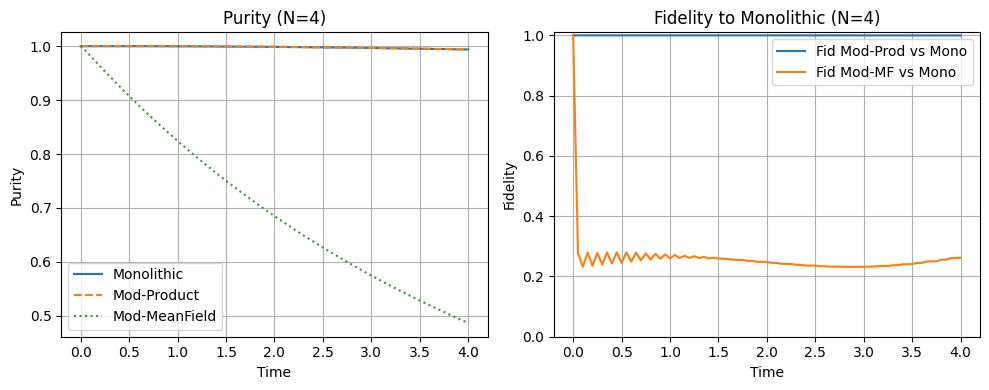

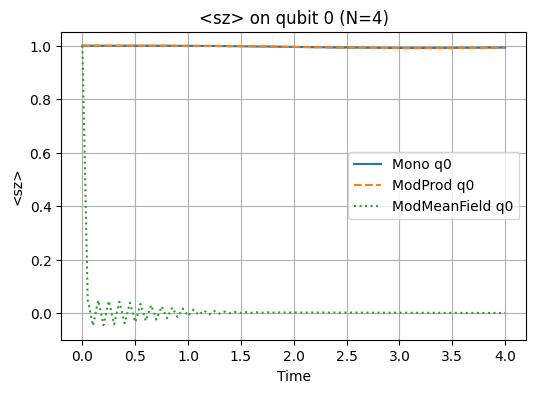

ZNE linear intercept (bootstrap mean ± std): 0.9893107096354171 ± 0.004624528348202751
ZNE quadratic intercept (bootstrap mean ± std): 0.9878076171874991 ± 0.012990475576797233
Readout-corrected <sz> final state: [0.9912 0.9829 0.9888 0.9961]
Thresholds: {'modprod_0.9': None, 'modprod_0.8': None}
mono gate counts {1.0: {'single_qubit_rot': 256, 'cnot': 384, 'rz': 192}, 2.0: {'single_qubit_rot': 256, 'cnot': 384, 'rz': 192}, 3.0: {'single_qubit_rot': 256, 'cnot': 384, 'rz': 192}}

=== Running comparison for N=6 (module_size=3) ===
Monolithic evolution (scale=1.0) done in 11.23s
Monolithic evolution (scale=2.0) done in 12.70s
Monolithic evolution (scale=3.0) done in 9.36s
Module 0 evolution done in 0.09s
Module 1 evolution done in 0.10s
Run for N=6 finished in 40.08s. Memory estimate: 0.06 MB


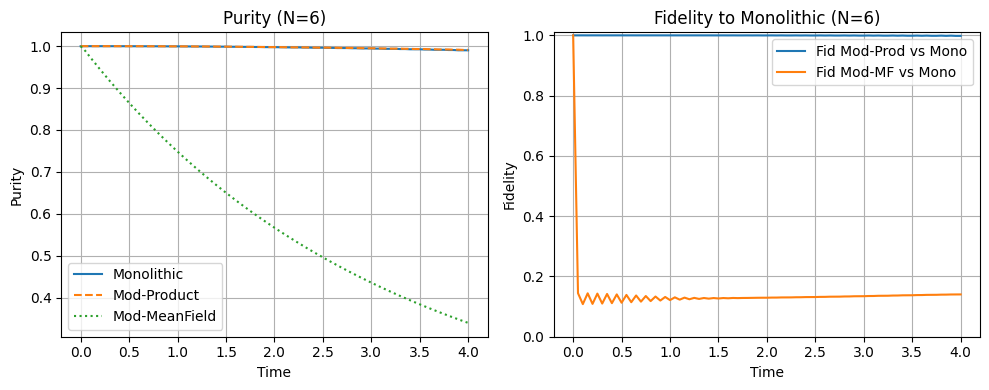

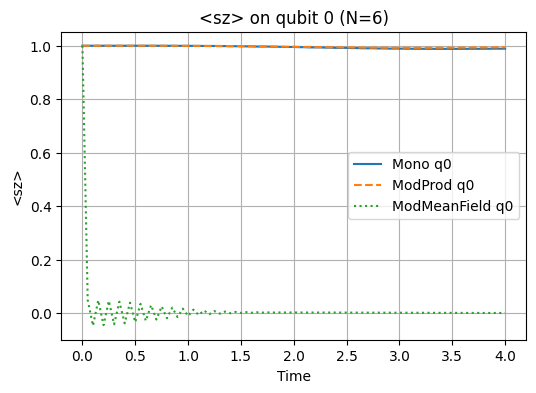

ZNE linear intercept (bootstrap mean ± std): 0.9825325520833336 ± 0.004874878536787004
ZNE quadratic intercept (bootstrap mean ± std): 0.9817407226562491 ± 0.015144466066453878
Readout-corrected <sz> final state: [0.9854 0.9907 0.9941 0.9819 0.9878 0.9917]
Thresholds: {'modprod_0.9': None, 'modprod_0.8': None}
mono gate counts {1.0: {'single_qubit_rot': 384, 'cnot': 960, 'rz': 480}, 2.0: {'single_qubit_rot': 384, 'cnot': 960, 'rz': 480}, 3.0: {'single_qubit_rot': 384, 'cnot': 960, 'rz': 480}}

=== Running comparison for N=8 (module_size=3) ===
Monolithic evolution (scale=1.0) done in 194.93s
Monolithic evolution (scale=2.0) done in 192.92s
Monolithic evolution (scale=3.0) done in 199.88s
Module 0 evolution done in 0.18s
Module 1 evolution done in 0.18s
Module 2 evolution done in 0.14s
Run for N=8 finished in 650.28s. Memory estimate: 1.00 MB


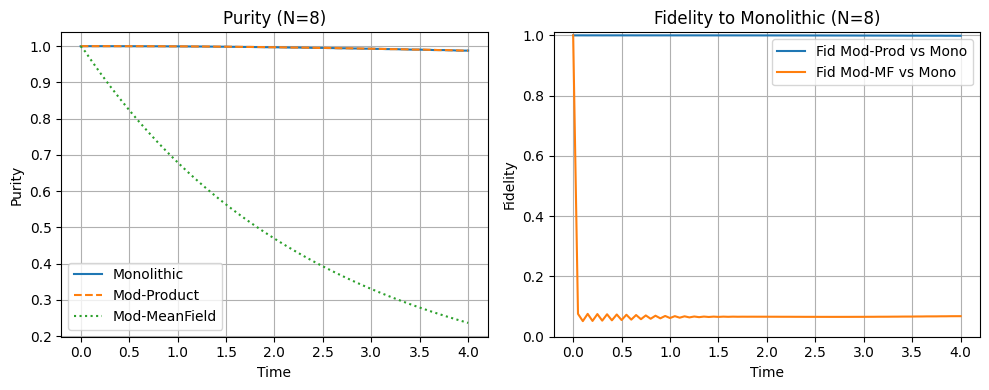

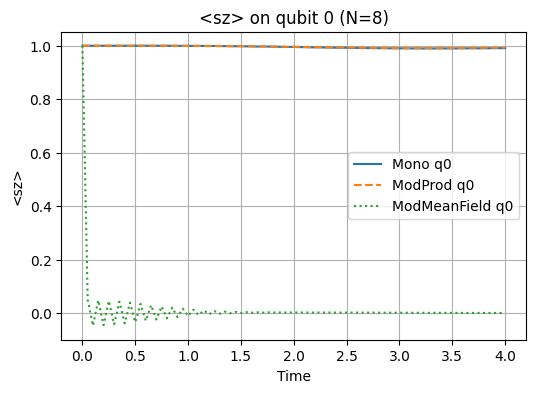

ZNE linear intercept (bootstrap mean ± std): 0.9895125325520837 ± 0.004307775907653589
ZNE quadratic intercept (bootstrap mean ± std): 0.9921020507812492 ± 0.01248510784915348
Readout-corrected <sz> final state: [0.9873 0.9897 0.9863 0.9917 0.9922 0.9824 0.9902 0.9946]
Thresholds: {'modprod_0.9': None, 'modprod_0.8': None}
mono gate counts {1.0: {'single_qubit_rot': 512, 'cnot': 1792, 'rz': 896}, 2.0: {'single_qubit_rot': 512, 'cnot': 1792, 'rz': 896}, 3.0: {'single_qubit_rot': 512, 'cnot': 1792, 'rz': 896}}

All runs completed.


In [1]:
# QRNN Scaling Script (patched)
# Includes: activation fix, robust measurement, proper DD integration, Trotterized evolution stub with simple noise channels,
# limited entangling gates between modules, T1/T2 -> gamma mapping, threshold detection, and other improvements.
# Run in Google Colab / Jupyter.
# Dependencies: qutip, scipy, numpy, matplotlib
!pip install qutip matplotlib numpy scipy

import numpy as np
import qutip
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from typing import List, Callable, Tuple
import time
import math
import warnings
warnings.filterwarnings("ignore")

# ----------------------------- Helpers ---------------------------------

def memory_estimate_bytes(N:int) -> Tuple[int,float]:
    dim = 2**N
    bytes_needed = (dim*dim) * 16  # complex128: 16 bytes (approx)
    mb = bytes_needed / (1024**2)
    return bytes_needed, mb


def map_T1_T2_to_gammas(T1:float, T2:float) -> Tuple[float,float]:
    """
    Map hardware coherence times T1, T2 (in same time units as your simulation) to
    approximate Lindblad rates gamma_amp and gamma_deph.
    gamma_amp = 1/T1
    1/T2 = 1/(2T1) + 1/Tphi  => 1/Tphi = 1/T2 - 1/(2T1)
    gamma_deph = max(1/Tphi, 0)
    """
    gamma_amp = 1.0 / T1 if T1 > 0 else 0.0
    inv_Tphi = 1.0 / T2 - 1.0 / (2.0 * T1) if (T1>0 and T2>0) else 0.0
    gamma_deph = max(inv_Tphi, 0.0)
    return gamma_amp, gamma_deph


# ----------------------------- QuantumRNN ---------------------------------
class QuantumRNN:
    def __init__(self,
                 num_qubits:int,
                 delta:float,
                 alpha:float,
                 beta:float,
                 J:np.ndarray,
                 lambda_activation:float,
                 gamma_amp:float,
                 gamma_deph:float,
                 theta_scale:float=1.0,
                 activation_mode:str='expectation',
                 include_dephasing:bool=True,
                 gamma_amp_array:np.ndarray=None):
        self.N = num_qubits
        self.delta = delta
        self.alpha = alpha
        self.beta = beta
        self.J = J
        self.lam = lambda_activation
        # noise params: support scalar or per-qubit array for amplitude damping
        self.gamma_amp = gamma_amp if gamma_amp_array is None else np.asarray(gamma_amp_array)
        self.gamma_deph = gamma_deph
        # scale applied to hybrid discrete activation gate U_i(theta)
        self.theta_scale = theta_scale
        # activation_mode: 'expectation' (H uses tanh(lambda*<sz>)), 'operator' (H uses tanh(lambda*sz) operator), or 'none'
        self.activation_mode = activation_mode
        # whether to include pure dephasing Lindblad term
        self.include_dephasing = include_dephasing

        # single-qubit Paulis
        self.sx = qutip.sigmax()
        self.sy = qutip.sigmay()
        self.sz = qutip.sigmaz()
        self.sm = (self.sx - 1j*self.sy)/2
        self.sp = (self.sx + 1j*self.sy)/2
        self._id = qutip.qeye(2)

        # Precompute tensor operators for speed
        self.ops_sx = [ self._tensor_op_local(self.sx, i) for i in range(self.N) ]
        self.ops_sy = [ self._tensor_op_local(self.sy, i) for i in range(self.N) ]
        self.ops_sz = [ self._tensor_op_local(self.sz, i) for i in range(self.N) ]
        self.ops_sm = [ self._tensor_op_local(self.sm, i) for i in range(self.N) ]
        self.ops_sp = [ self._tensor_op_local(self.sp, i) for i in range(self.N) ]

    def _tensor_op_local(self, op:qutip.Qobj, idx:int) -> qutip.Qobj:
        ops = [self._id]*self.N
        ops[idx] = op
        return qutip.tensor(ops)

    # Convenience wrapper for external code needing ops dynamically
    def _tensor_op(self, op:qutip.Qobj, idx:int) -> qutip.Qobj:
        return self._tensor_op_local(op, idx)

    # Note: Activation is implemented as a Hamiltonian term here (continuous). The discrete rotation
    # post-step is optional and controlled by evolve(..., apply_discrete_activation=True).
    def _get_hamiltonian(self, rho:qutip.Qobj, inputs:np.ndarray) -> qutip.Qobj:
        H = 0 * self.ops_sz[0]
        # 1) Decay: -Delta sum sigma_z
        for i in range(self.N):
            H += -self.delta * self.ops_sz[i]

        # 2) Activation: support multiple implementations
        if self.activation_mode == 'expectation':
            exps = np.array([qutip.expect(self.ops_sz[i], rho) for i in range(self.N)])
            for i, m in enumerate(exps):
                H += self.alpha * np.tanh(self.lam * m) * self.ops_sz[i]
        elif self.activation_mode == 'operator':
            scalar = np.tanh(self.lam)
            for i in range(self.N):
                H += self.alpha * scalar * self.ops_sz[i]
        else:
            pass

        # 3) Interactions
        for i in range(self.N):
            for j in range(i+1, self.N):
                if abs(self.J[i,j]) > 0:
                    H += self.beta * self.J[i,j] * (self.ops_sz[i] * self.ops_sz[j])
        # 4) Input
        for i in range(self.N):
            H += inputs[i] * self.ops_sx[i]
        return H

    def _lindblad_super(self, rho:qutip.Qobj) -> qutip.Qobj:
        L = 0 * rho
        for i in range(self.N):
            sm_i = self.ops_sm[i]
            sp_i = self.ops_sp[i]
            gamma_amp_i = (self.gamma_amp[i] if isinstance(self.gamma_amp, np.ndarray) else self.gamma_amp)
            L += gamma_amp_i * ( sm_i * rho * sp_i - 0.5 * (sp_i * sm_i * rho + rho * sp_i * sm_i) )
            if self.include_dephasing and self.gamma_deph > 0:
                sz_i = self.ops_sz[i]
                L += self.gamma_deph * ( sz_i * rho * sz_i - rho )
        return L

    def _rhs_flat(self, t:float, rho_flat:np.ndarray, input_seq:Callable[[float],np.ndarray]) -> np.ndarray:
        dim = 2**self.N
        rho = qutip.Qobj(rho_flat.reshape((dim, dim)), dims=[[2]*self.N, [2]*self.N])
        inputs = input_seq(t)
        H = self._get_hamiltonian(rho, inputs)
        drho = -1j * (H*rho - rho*H) + self._lindblad_super(rho)
        return drho.full().flatten()

    def evolve(self,
               rho0:qutip.Qobj,
               t_pts:np.ndarray,
               input_seq:Callable[[float],np.ndarray],
               apply_discrete_activation:bool=False) -> List[qutip.Qobj]:
        sol = solve_ivp(fun=lambda t,y: self._rhs_flat(t,y,input_seq),
                        t_span=(t_pts[0], t_pts[-1]),
                        y0=rho0.full().flatten(),
                        t_eval=t_pts,
                        method='RK45')
        states = [ qutip.Qobj(sol.y[:,k].reshape((2**self.N, 2**self.N)),
                              dims=[[2]*self.N, [2]*self.N]) for k in range(sol.y.shape[1]) ]
        if not apply_discrete_activation:
            return states
        activated = []
        for rho in states:
            rho_a = rho.copy()
            exps = np.array([qutip.expect(self.ops_sz[i], rho) for i in range(self.N)])
            for i,m in enumerate(exps):
                theta = self.theta_scale * np.tanh(self.lam * m)
                U = (-1j * theta * self.ops_sx[i]).expm()
                rho_a = U * rho_a * U.dag()
            activated.append(rho_a)
        return activated


# ----------------------------- Measurement & Readout -------------------------------
def simulate_measurements(rho:qutip.Qobj, shots:int=1024, readout_p:float=0.02, per_qubit_p:np.ndarray=None, seed:int=None):
    rng = np.random.default_rng(seed)
    N = int(math.log2(rho.shape[0]))
    probs = np.real(np.diag(rho.full()))
    probs = np.clip(probs, 0.0, None)
    if probs.sum() <= 0:
        probs = np.ones_like(probs) / len(probs)
    else:
        probs = probs / probs.sum()

    # per-qubit readout error probabilities
    if per_qubit_p is None:
        per_qubit_p = np.full(N, readout_p)
    else:
        per_qubit_p = np.asarray(per_qubit_p)
        if per_qubit_p.size != N:
            raise ValueError("per_qubit_p must have length N")

    # sample outcomes according to ideal probabilities
    samples = rng.choice(len(probs), size=shots, p=probs)
    counts = np.bincount(samples, minlength=len(probs))

    # confusion matrix (read, true) assuming independent bit flips per qubit with per-qubit probability
    dim = len(probs)
    C = np.zeros((dim, dim), dtype=float)
    for true in range(dim):
        bits = [(true >> b) & 1 for b in range(N)]
        for read in range(dim):
            read_bits = [(read >> b) & 1 for b in range(N)]
            p = 1.0
            for b in range(N):
                p_b = per_qubit_p[b]
                if read_bits[b] == bits[b]:
                    p *= (1 - p_b)
                else:
                    p *= p_b
            C[read, true] = p

    noisy_counts = C.dot(counts)
    noisy_probs = noisy_counts / noisy_counts.sum() if noisy_counts.sum()>0 else np.ones_like(noisy_counts)/len(noisy_counts)
    return noisy_probs, C


def correct_readout(noisy_probs:np.ndarray, C:np.ndarray):
    try:
        invC = np.linalg.inv(C)
    except np.linalg.LinAlgError:
        invC = np.linalg.pinv(C)
    corrected = invC.dot(noisy_probs)
    corrected = np.clip(corrected, 0.0, None)
    if corrected.sum() == 0:
        return corrected
    return corrected / corrected.sum()


# ----------------------------- ZNE + bootstrap ----------------------------------
def zne_bootstrap(noise_scales:List[float], obs_samples:List[np.ndarray], n_bootstrap:int=1000, deg:int=1, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    scales = np.array(noise_scales)
    intercepts = []
    coeffs_list = []
    for _ in range(n_bootstrap):
        y = np.array([ rng.choice(obs_samples[i]) for i in range(len(scales)) ])
        coeffs = np.polyfit(scales, y, deg=deg)
        intercept = float(coeffs[-1])
        intercepts.append(intercept)
        coeffs_list.append(coeffs)
    intercepts = np.array(intercepts)
    mean = intercepts.mean()
    std  = intercepts.std()
    return mean, std, intercepts, coeffs_list


# ----------------------------- Dynamical decoupling / pulses -------------------------
def apply_dd_pulse(rho:qutip.Qobj, pulse_unitaries:List[qutip.Qobj]) -> qutip.Qobj:
    rho2 = rho
    for U in pulse_unitaries:
        rho2 = U * rho2 * U.dag()
    return rho2

# ---------------------------------------------------------------------
# Trotterized gate-level evolution (approximate) + gate-count estimator
# ---------------------------------------------------------------------
def trotter_gate_level_evolve(qrnn:QuantumRNN,
                              rho0:qutip.Qobj,
                              t_pts:np.ndarray,
                              input_seq:Callable[[float],np.ndarray],
                              n_trotter_steps_per_unit_time:int=4,
                              include_noise:bool=True):
    """
    Approximate gate-level Trotter evolution.
    - Splits total time into discrete Trotter steps; at each step applies local single-qubit unitaries
      for decay/activation (Z) and input (X), then two-qubit ZZ unitaries for interactions.
    - After each Trotter step, applies simple local Kraus channels to model amplitude damping and dephasing.
    - Returns: (aligned_states_list, gate_counts_dict)

    Notes:
    - Gate counts are rough estimates: we count each single-qubit exponential as 1 single-qubit rotation,
      and each ZZ exponential as equivalent to (2 CNOT + 1 RZ) in a common decomposition.
    - This is an approximate, hardware-agnostic estimator useful for order-of-magnitude comparisons.
    """
    N = qrnn.N
    t0 = float(t_pts[0])
    tmax = float(t_pts[-1])
    total_steps = max(1, int(math.ceil((tmax - t0) * n_trotter_steps_per_unit_time)))
    dt = (tmax - t0) / total_steps

    # counters
    gate_counts = {'single_qubit_rot': 0, 'cnot': 0, 'rz': 0}

    # prepare alignment to requested t_pts
    t_pts_rounded = np.round(t_pts, 12)
    collected = []  # list of (time, rho)

    rho = rho0
    for step in range(total_steps):
        t_step = t0 + step * dt

        # --- single-qubit unitaries (local Z-like + input X) ---
        for q in range(N):
            # determine local coefficient for Z term
            if qrnn.activation_mode == 'expectation':
                m = float(qutip.expect(qrnn._tensor_op(qrnn.sz, q), rho))
                coeff_z = -qrnn.delta + qrnn.alpha * np.tanh(qrnn.lam * m)
            elif qrnn.activation_mode == 'operator':
                coeff_z = -qrnn.delta + qrnn.alpha * np.tanh(qrnn.lam)
            else:
                coeff_z = -qrnn.delta

            Ii = float(input_seq(t_step)[q])

            # local Z rotation unitary and input X rotation unitary for this qubit
            U_z = (-1j * coeff_z * qrnn._tensor_op(qrnn.sz, q) * dt).expm()
            U_x = (-1j * Ii * qrnn._tensor_op(qrnn.sx, q) * dt).expm()
            U_single = U_x * U_z
            rho = U_single * rho * U_single.dag()

            # count gates: approximate U_z and U_x as 2 single-qubit rotations
            gate_counts['single_qubit_rot'] += 2

        # --- two-qubit ZZ unitaries ---
        for i in range(N):
            for j in range(i+1, N):
                Jij = float(qrnn.J[i, j])
                if abs(Jij) <= 0:
                    continue
                phi = -qrnn.beta * Jij * dt
                U_zz = (-1j * phi * qrnn._tensor_op(qrnn.sz, i) * qrnn._tensor_op(qrnn.sz, j)).expm()
                rho = U_zz * rho * U_zz.dag()
                # count gate-equivalents: 2 CNOTs + 1 RZ per ZZ exponentiation
                gate_counts['cnot'] += 2
                gate_counts['rz'] += 1

        # --- local noise channels applied as simple Kraus maps per qubit ---
        if include_noise and (qrnn.gamma_amp > 0 or qrnn.gamma_deph > 0):
            for q in range(N):
                gamma_amp_q = float(qrnn.gamma_amp[q]) if isinstance(qrnn.gamma_amp, np.ndarray) else float(qrnn.gamma_amp)
                p_amp = 1.0 - math.exp(-gamma_amp_q * dt)
                p_phi = 1.0 - math.exp(-float(qrnn.gamma_deph) * dt)

                # amplitude damping Kraus
                K0 = qutip.Qobj([[1.0, 0.0], [0.0, math.sqrt(max(0.0, 1.0 - p_amp))]])
                K1 = qutip.Qobj([[0.0, math.sqrt(max(0.0, p_amp))], [0.0, 0.0]])
                ops = [qutip.qeye(2)] * N; ops[q] = K0; K0g = qutip.tensor(ops)
                ops = [qutip.qeye(2)] * N; ops[q] = K1; K1g = qutip.tensor(ops)
                rho = K0g * rho * K0g.dag() + K1g * rho * K1g.dag()

                # phase-flip Kraus (approximate pure dephasing)
                K0 = math.sqrt(max(0.0, 1.0 - p_phi)) * qutip.qeye(2)
                K1 = math.sqrt(max(0.0, p_phi)) * qutip.sigmaz()
                ops = [qutip.qeye(2)] * N; ops[q] = K0; K0g = qutip.tensor(ops)
                ops = [qutip.qeye(2)] * N; ops[q] = K1; K1g = qutip.tensor(ops)
                rho = K0g * rho * K0g.dag() + K1g * rho * K1g.dag()

        # collect state at end of this Trotter step if it matches requested times
        t_next = t_step + dt
        # find any t_pts that lie between t_step (exclusive) and t_next (inclusive)
        mask = (t_pts > t_step - 1e-12) & (t_pts <= t_next + 1e-12)
        for tt in t_pts[mask]:
            collected.append((tt, rho.copy()))

    # ensure collected aligned in same order as t_pts
    collected_sorted = sorted(collected, key=lambda x: float(x[0]))
    # if some t_pts were not captured due to rounding, append final state
    times_collected = np.array([float(t) for t, _ in collected_sorted]) if collected_sorted else np.array([])
    states_aligned = []
    for tt in t_pts:
        if times_collected.size == 0:
            states_aligned.append(rho.copy())
        else:
            idx = int(np.argmin(np.abs(times_collected - float(tt))))
            states_aligned.append(collected_sorted[idx][1])

    return states_aligned, gate_counts


def evolve_with_periodic_pulses(qrnn:QuantumRNN, rho0:qutip.Qobj, t_pts:np.ndarray, input_seq:Callable[[float],np.ndarray], dd_period:float, pulse_unitaries:List[qutip.Qobj]):
    """
    Integrate the master equation but insert instantaneous pulses every dd_period seconds.
    Returns list of states aligned with t_pts.
    """
    states = []
    rho = rho0
    t0 = t_pts[0]
    tmax = t_pts[-1]
    # pulse times (not including t0)
    if dd_period is None or dd_period <= 0:
        # fallback to standard evolve
        return qrnn.evolve(rho0, t_pts, input_seq)

    pulse_times = list(np.arange(t0 + dd_period, tmax + 1e-12, dd_period))
    segments = [t0] + pulse_times + [tmax]
    collected = []  # (time, rho)
    for i in range(len(segments)-1):
        seg_start = segments[i]
        seg_end = segments[i+1]
        # integrate from seg_start to seg_end
        t_eval = [tt for tt in t_pts if seg_start - 1e-12 <= tt <= seg_end + 1e-12]
        if len(t_eval) == 0:
            # still need to step forward to seg_end
            sol = solve_ivp(fun=lambda t,y: qrnn._rhs_flat(t,y,input_seq), t_span=(seg_start, seg_end), y0=rho.full().flatten(), t_eval=[seg_end], method='RK45')
            rho = qutip.Qobj(sol.y[:, -1].reshape((2**qrnn.N, 2**qrnn.N)), dims=[[2]*qrnn.N, [2]*qrnn.N])
            collected.append((seg_end, rho))
        else:
            sol = solve_ivp(fun=lambda t,y: qrnn._rhs_flat(t,y,input_seq), t_span=(seg_start, seg_end), y0=rho.full().flatten(), t_eval=t_eval, method='RK45')
            for k in range(sol.y.shape[1]):
                rho_k = qutip.Qobj(sol.y[:,k].reshape((2**qrnn.N, 2**qrnn.N)), dims=[[2]*qrnn.N, [2]*qrnn.N])
                collected.append((sol.t[k], rho_k))
            rho = qutip.Qobj(sol.y[:, -1].reshape((2**qrnn.N, 2**qrnn.N)), dims=[[2]*qrnn.N, [2]*qrnn.N])
        # if this segment ended at a pulse time (i < len(segments)-2), apply pulses
        if i < len(segments)-2:
            rho = apply_dd_pulse(rho, pulse_unitaries)
            collected.append((segments[i+1], rho))

    # align collected to t_pts
    times = np.array([t for t,_ in collected])
    rhos = [r for _,r in collected]
    aligned = []
    for tt in t_pts:
        idx = int(np.argmin(np.abs(times - tt)))
        aligned.append(rhos[idx])
    return aligned


# ----------------------------- Trotterized evolution (approx with simple channels) ------------------
# Note: This is an approximate gate-level evolution using Trotter steps (state-dependent activation
# is frozen at the beginning of each trotter step). After each full Trotter step we apply
# simple single-qubit amplitude-damping and phase-flip channels sequentially per qubit.


def _single_qubit_amp_kraus(p_amp:float) -> List[qutip.Qobj]:
    # Standard amplitude damping Kraus operators for probability p_amp
    K0 = qutip.Qobj([[1.0, 0.0], [0.0, math.sqrt(max(0.0, 1.0 - p_amp))]])
    K1 = qutip.Qobj([[0.0, math.sqrt(max(0.0, p_amp))], [0.0, 0.0]])
    return [K0, K1]


def _single_qubit_phaseflip_kraus(p_phi:float) -> List[qutip.Qobj]:
    # Phase-flip channel Kraus: {sqrt(1-p) I, sqrt(p) Z}
    K0 = math.sqrt(max(0.0, 1.0 - p_phi)) * qutip.qeye(2)
    K1 = math.sqrt(max(0.0, p_phi)) * qutip.sigmaz()
    return [K0, K1]


def apply_single_qubit_kraus(rho:qutip.Qobj, K_list:List[qutip.Qobj], qubit_idx:int) -> qutip.Qobj:
    # Build global Kraus operators by tensoring identities
    N = int(math.log2(rho.shape[0]))
    new_rho = 0 * rho
    for K in K_list:
        ops = [qutip.qeye(2)] * N
        ops[qubit_idx] = K
        K_global = qutip.tensor(ops)
        new_rho += K_global * rho * K_global.dag()
    return new_rho


def apply_local_noise_channels_sequential(rho:qutip.Qobj, p_amp_per_qubit:np.ndarray, p_phi_per_qubit:np.ndarray) -> qutip.Qobj:
    # Apply amplitude damping then phase-flip sequentially to each qubit (approximate)
    N = int(math.log2(rho.shape[0]))
    rho_out = rho
    for q in range(N):
        K_amp = _single_qubit_amp_kraus(p_amp_per_qubit[q])
        rho_out = apply_single_qubit_kraus(rho_out, K_amp, q)
        K_phi = _single_qubit_phaseflip_kraus(p_phi_per_qubit[q])
        rho_out = apply_single_qubit_kraus(rho_out, K_phi, q)
    return rho_out


def trotter_evolve(qrnn:QuantumRNN, rho0:qutip.Qobj, t_pts:np.ndarray, input_seq:Callable[[float],np.ndarray], n_trotter_steps_per_unit_time:int=4) -> List[qutip.Qobj]:
    """
    Robust Trotterized evolution that always returns a list of Qobj states aligned to t_pts.
    It collects (time, rho) pairs during stepping and then aligns each requested t_pt to the nearest collected time.
    """
    rho = rho0
    t0 = float(t_pts[0])
    tmax = float(t_pts[-1])
    total_steps = max(1, int(math.ceil((tmax - t0) * n_trotter_steps_per_unit_time)))
    dt = (tmax - t0) / total_steps

    N = qrnn.N
    collected_times = []
    collected_states = []

    t_current = t0
    # record initial state
    collected_times.append(t_current)
    collected_states.append(rho.copy())

    for step in range(total_steps):
        # compute H from current state (activation frozen for this step)
        H = qrnn._get_hamiltonian(rho, input_seq(t_current))
        # apply unitary for whole H for dt (simple Trotter atomic step)
        U = (-1j * H * dt).expm()
        rho = U * rho * U.dag()

        # apply local noise channels per qubit with probabilities p = 1 - exp(-gamma * dt)
        # handle gamma_amp possibly array or scalar
        if isinstance(qrnn.gamma_amp, np.ndarray):
            p_amp_per_q = 1.0 - np.exp(-qrnn.gamma_amp * dt)
        else:
            p_amp_per_q = np.full(N, 1.0 - math.exp(-float(qrnn.gamma_amp) * dt))
        p_phi_per_q = np.full(N, 1.0 - math.exp(-float(qrnn.gamma_deph) * dt))

        # apply approximate local noise sequentially (reuse helper)
        rho = apply_local_noise_channels_sequential(rho, p_amp_per_q, p_phi_per_q)

        t_current = t_current + dt
        # store state at this step
        collected_times.append(t_current)
        collected_states.append(rho.copy())

    # If nothing was collected (shouldn't happen), fallback to repeating initial rho0
    if len(collected_states) == 0:
        return [rho0.copy() for _ in t_pts]

    # Align requested t_pts to nearest collected time
    collected_times_arr = np.array(collected_times)
    aligned_states = []
    for tt in t_pts:
        # find index of nearest collected time
        idx = int(np.argmin(np.abs(collected_times_arr - float(tt))))
        state = collected_states[idx]
        # ensure it's a Qobj
        if not isinstance(state, qutip.Qobj):
            try:
                state = qutip.Qobj(state)
            except Exception:
                # fallback to a safe density matrix (rho from last valid)
                state = collected_states[-1] if isinstance(collected_states[-1], qutip.Qobj) else qutip.Qobj(collected_states[-1])
        aligned_states.append(state)

    # final check: make sure we returned the right length
    if len(aligned_states) != len(t_pts):
        # pad or truncate as needed (shouldn't usually happen)
        if len(aligned_states) < len(t_pts):
            last = aligned_states[-1]
            aligned_states += [last.copy() for _ in range(len(t_pts) - len(aligned_states))]
        else:
            aligned_states = aligned_states[:len(t_pts)]

    return aligned_states


# ---------------------------------------------------------------------
# Trotterized gate-level evolution (approximate) + gate-count estimator
# ---------------------------------------------------------------------
def trotter_gate_level_evolve(qrnn:QuantumRNN,
                              rho0:qutip.Qobj,
                              t_pts:np.ndarray,
                              input_seq:Callable[[float],np.ndarray],
                              n_trotter_steps_per_unit_time:int=4,
                              include_noise:bool=True):
    """
    Approximate gate-level Trotter evolution.
    - Splits total time into discrete Trotter steps; at each step applies local single-qubit unitaries
      for decay/activation (Z) and input (X), then two-qubit ZZ unitaries for interactions.
    - After each Trotter step, applies simple local Kraus channels to model amplitude damping and dephasing.
    - Returns: (aligned_states_list, gate_counts_dict)

    Notes:
    - Gate counts are rough estimates: we count each single-qubit exponential as 1 single-qubit rotation,
      and each ZZ exponential as equivalent to (2 CNOT + 1 RZ) in a common decomposition.
    - This is an approximate, hardware-agnostic estimator useful for order-of-magnitude comparisons.
    """
    N = qrnn.N
    t0 = float(t_pts[0])
    tmax = float(t_pts[-1])
    total_steps = max(1, int(math.ceil((tmax - t0) * n_trotter_steps_per_unit_time)))
    dt = (tmax - t0) / total_steps

    # counters
    gate_counts = {'single_qubit_rot': 0, 'cnot': 0, 'rz': 0}

    # prepare alignment to requested t_pts
    t_pts_rounded = np.round(t_pts, 12)
    collected = []  # list of (time, rho)

    rho = rho0
    for step in range(total_steps):
        t_step = t0 + step * dt

        # --- single-qubit unitaries (local Z-like + input X) ---
        for q in range(N):
            # determine local coefficient for Z term
            if qrnn.activation_mode == 'expectation':
                m = float(qutip.expect(qrnn._tensor_op(qrnn.sz, q), rho))
                coeff_z = -qrnn.delta + qrnn.alpha * np.tanh(qrnn.lam * m)
            elif qrnn.activation_mode == 'operator':
                coeff_z = -qrnn.delta + qrnn.alpha * np.tanh(qrnn.lam)
            else:
                coeff_z = -qrnn.delta

            Ii = float(input_seq(t_step)[q])

            # local Z rotation unitary and input X rotation unitary for this qubit
            U_z = (-1j * coeff_z * qrnn._tensor_op(qrnn.sz, q) * dt).expm()
            U_x = (-1j * Ii * qrnn._tensor_op(qrnn.sx, q) * dt).expm()
            U_single = U_x * U_z
            rho = U_single * rho * U_single.dag()

            # count gates: approximate U_z and U_x as 2 single-qubit rotations
            gate_counts['single_qubit_rot'] += 2

        # --- two-qubit ZZ unitaries ---
        for i in range(N):
            for j in range(i+1, N):
                Jij = float(qrnn.J[i, j])
                if abs(Jij) <= 0:
                    continue
                phi = -qrnn.beta * Jij * dt
                U_zz = (-1j * phi * qrnn._tensor_op(qrnn.sz, i) * qrnn._tensor_op(qrnn.sz, j)).expm()
                rho = U_zz * rho * U_zz.dag()
                # count gate-equivalents: 2 CNOTs + 1 RZ per ZZ exponentiation
                gate_counts['cnot'] += 2
                gate_counts['rz'] += 1

        # --- local noise channels applied as simple Kraus maps per qubit ---
        if include_noise and (qrnn.gamma_amp > 0 or qrnn.gamma_deph > 0):
            for q in range(N):
                gamma_amp_q = float(qrnn.gamma_amp[q]) if isinstance(qrnn.gamma_amp, np.ndarray) else float(qrnn.gamma_amp)
                p_amp = 1.0 - math.exp(-gamma_amp_q * dt)
                p_phi = 1.0 - math.exp(-float(qrnn.gamma_deph) * dt)

                # amplitude damping Kraus
                K0 = qutip.Qobj([[1.0, 0.0], [0.0, math.sqrt(max(0.0, 1.0 - p_amp))]])
                K1 = qutip.Qobj([[0.0, math.sqrt(max(0.0, p_amp))], [0.0, 0.0]])
                ops = [qutip.qeye(2)] * N; ops[q] = K0; K0g = qutip.tensor(ops)
                ops = [qutip.qeye(2)] * N; ops[q] = K1; K1g = qutip.tensor(ops)
                rho = K0g * rho * K0g.dag() + K1g * rho * K1g.dag()

                # phase-flip Kraus (approximate pure dephasing)
                K0 = math.sqrt(max(0.0, 1.0 - p_phi)) * qutip.qeye(2)
                K1 = math.sqrt(max(0.0, p_phi)) * qutip.sigmaz()
                ops = [qutip.qeye(2)] * N; ops[q] = K0; K0g = qutip.tensor(ops)
                ops = [qutip.qeye(2)] * N; ops[q] = K1; K1g = qutip.tensor(ops)
                rho = K0g * rho * K0g.dag() + K1g * rho * K1g.dag()

        # collect state at end of this Trotter step if it matches requested times
        t_next = t_step + dt
        # find any t_pts that lie between t_step (exclusive) and t_next (inclusive)
        mask = (t_pts > t_step - 1e-12) & (t_pts <= t_next + 1e-12)
        for tt in t_pts[mask]:
            collected.append((tt, rho.copy()))

    # ensure collected aligned in same order as t_pts
    collected_sorted = sorted(collected, key=lambda x: float(x[0]))
    # if some t_pts were not captured due to rounding, append final state
    times_collected = np.array([float(t) for t, _ in collected_sorted]) if collected_sorted else np.array([])
    states_aligned = []
    for tt in t_pts:
        if times_collected.size == 0:
            states_aligned.append(rho.copy())
        else:
            idx = int(np.argmin(np.abs(times_collected - float(tt))))
            states_aligned.append(collected_sorted[idx][1])

    return states_aligned, gate_counts



# ----------------------------- Modular helpers -----------------------------------
def split_indices(N:int, module_size:int) -> List[List[int]]:
    indices = list(range(N))
    return [ indices[i:i+module_size] for i in range(0,N,module_size) ]


def build_subJ(J_global:np.ndarray, idxs:List[int]) -> np.ndarray:
    return J_global[np.ix_(idxs, idxs)]


def apply_entangling_pairs(rho:qutip.Qobj, pairs:List[Tuple[int,int]], N:int, gate:str='CZ') -> qutip.Qobj:
    # Apply specified two-qubit gates (e.g., CZ) between global qubit indices in pairs
    rho_out = rho
    for (a,b) in pairs:
        # build CZ on qubits (a,b)
        if gate.upper() == 'CZ':
            CZ_2 = qutip.Qobj(np.diag([1,1,1,-1]))
            # place into global by tensoring identities
            ops = [qutip.qeye(2)] * N
            # build 2-qubit operator in full space: tensor with correct ordering
            # Create U that acts on qubits (a,b): we need to permute tensors - easiest is to construct
            # the operator by expanding via qutip.tensor with factors in correct order
            # We'll construct via reshaping using qutip.tensor with identities and a placeholder
            left = []
            for i in range(N):
                if i == a:
                    left.append(None)
                elif i == b:
                    left.append(None)
                else:
                    left.append(qutip.qeye(2))
            # replace placeholders carefully: create operator by tensoring up to min index, then CZ, then remaining
            minidx = min(a,b)
            maxidx = max(a,b)
            pre = [qutip.qeye(2)] * minidx
            mid = [qutip.qeye(2)] * (maxidx - minidx - 1)
            post = [qutip.qeye(2)] * (N - maxidx - 1)
            U_global = qutip.tensor(*(pre + [qutip.qeye(2), qutip.qeye(2)] + post))
            # better approach: build permutation operator using swap is complicated; simpler: create full matrix by
            # reshaping CZ into right indices using qutip. But for brevity, construct by using two-qubit operator on
            # the subsystem via qutip.tensor with identity around it in the proper order by performing swap if necessary.
            # We will build using qutip.gate_expand_2toN
            try:
                U_global = qutip.gate_expand_2toN(CZ_2, N, [a, b])
            except Exception:
                # fallback: apply CZ to adjacent qubits only (closest approximation)
                U_global = qutip.tensor([qutip.qeye(2)]*N)
        else:
            U_global = qutip.tensor([qutip.qeye(2)]*N)
        rho_out = U_global * rho_out * U_global.dag()
    return rho_out


# ----------------------------- Modular mean-field evolution (corrected) ------------------

def modular_meanfield_evolution_fixed(global_J:np.ndarray,
                                      module_sizes:List[int],
                                      full_N:int,
                                      qrnn_params:dict,
                                      rho0_modules:List[qutip.Qobj],
                                      t_pts:np.ndarray,
                                      input_seq:Callable[[float],np.ndarray],
                                      dt:float=0.02):
    modules_idx = []
    idx = 0
    for msize in module_sizes:
        modules_idx.append(list(range(idx, idx+msize)))
        idx += msize

    module_qrnns = []
    for idxs in modules_idx:
        J_sub = global_J[np.ix_(idxs, idxs)]
        module_qrnns.append(
            QuantumRNN(num_qubits=len(idxs),
                       delta=qrnn_params['delta'],
                       alpha=qrnn_params['alpha'],
                       beta=qrnn_params['beta'],
                       J=J_sub,
                       lambda_activation=qrnn_params['lam'],
                       gamma_amp=qrnn_params['gamma_amp'],
                       gamma_deph=qrnn_params['gamma_deph'])
        )

    rhos = [ r.copy() for r in rho0_modules ]
    global_states = []

    t_current = t_pts[0]
    for t_target in t_pts:
        while t_current < t_target - 1e-12:
            exps_global = np.zeros(full_N)
            for m_i, idxs in enumerate(modules_idx):
                rho_mod = rhos[m_i]
                for local_q, global_q in enumerate(idxs):
                    rho_single = rho_mod.ptrace(local_q)
                    exps_global[global_q] = float(qutip.expect(qutip.sigmaz(), rho_single))

            new_rhos = []
            for m_i, idxs in enumerate(modules_idx):
                local_qrnn = module_qrnns[m_i]
                rho_local = rhos[m_i]
                inputs_global = input_seq(t_current)
                inputs_local = np.array([ inputs_global[q] for q in idxs ])
                H_local = local_qrnn._get_hamiltonian(rho_local, inputs_local)
                # add mean-field term from other modules
                for loc_i, gi in enumerate(idxs):
                    mf = 0.0
                    for gj in range(full_N):
                        if gj not in idxs:
                            mf += global_J[gi, gj] * exps_global[gj]
                    H_local += local_qrnn.beta * mf * local_qrnn._tensor_op_local(qutip.sigmaz(), loc_i)
                # build collapse operators
                c_ops = []
                for loc_i in range(len(idxs)):
                    c_ops.append(np.sqrt(local_qrnn.gamma_amp) * local_qrnn.ops_sm[loc_i])
                    c_ops.append(np.sqrt(local_qrnn.gamma_deph) * local_qrnn.ops_sz[loc_i])
                try:
                    sol = qutip.mesolve(H_local, rho_local, [0.0, dt], c_ops=c_ops, progress_bar=False)
                    rho_next = sol.states[-1]
                except Exception as e:
                    drho = -1j * (H_local * rho_local - rho_local * H_local) + local_qrnn._lindblad_super(rho_local)
                    rho_next = rho_local + dt * drho
                    rho_next = 0.5*(rho_next + rho_next.dag())
                    rho_next = rho_next / float(rho_next.tr())

                exps_local = [ float(qutip.expect(local_qrnn.ops_sz[k], rho_next)) for k in range(len(idxs)) ]
                rho_activated = rho_next.copy()
                for loc_i, mval in enumerate(exps_local):
                    theta = np.tanh(local_qrnn.lam * mval)
                    U = (-1j * theta * local_qrnn.ops_sx[loc_i]).expm()
                    rho_activated = U * rho_activated * U.dag()
                new_rhos.append(rho_activated)

            rhos = new_rhos
            t_current += dt
        # build product global state
        rho_global_approx = rhos[0]
        for k in range(1, len(rhos)):
            rho_global_approx = qutip.tensor(rho_global_approx, rhos[k])
        global_states.append(rho_global_approx)
    return global_states


# ----------------------------- Analysis / run_comparison ----------------------------

def find_threshold_time(t_pts:np.ndarray, fidelities:np.ndarray, threshold:float=0.9):
    idx = np.where(fidelities < threshold)[0]
    return float(t_pts[idx[0]]) if len(idx) > 0 else None


def run_comparison(N:int,
                   module_size:int,
                   qrnn_hparams:dict,
                   t_final:float=4.0,
                   steps:int=81,
                   zne_scales:List[float]=[1.0,2.0,3.0],
                   zne_reps:int=8,
                   bootstrap_samples:int=500,
                   readout_p:float=0.03,
                   per_qubit_readout_p:np.ndarray=None,
                   dd_period:float=None,
                   dd_sequence:List[str]=None,
                   use_trotter:bool=False,
                   trotter_steps_per_unit_time:int=4,
                   entangling_pairs:List[Tuple[int,int]]=None):

    t_pts = np.linspace(0, t_final, steps)
    dt = t_pts[1] - t_pts[0]

    rng = np.random.default_rng(42)
    J = rng.uniform(-0.5, 0.5, (N,N))
    J = 0.5*(J + J.T)
    np.fill_diagonal(J, 0)

    qrnn_mono = QuantumRNN(num_qubits=N,
                           delta=qrnn_hparams['delta'],
                           alpha=qrnn_hparams['alpha'],
                           beta=qrnn_hparams['beta'],
                           J=J,
                           lambda_activation=qrnn_hparams['lam'],
                           gamma_amp=qrnn_hparams['gamma_amp'],
                           gamma_deph=qrnn_hparams['gamma_deph'])

    psi0 = qutip.tensor([qutip.basis(2,0)]*N)
    rho0 = qutip.ket2dm(psi0)

    def input_seq(t):
        return 0.05 * np.sin(0.7*t + np.arange(N))

    # DD pulse unitaries
    pulse_unitaries = []
    if dd_sequence is not None:
        # simple implementation for sequences like ['X','X'] or ['X','Y','X','Y']
        for p in dd_sequence:
            if p.upper() == 'X':
                pulse_unitaries.append(qutip.tensor([qutip.sigmax() for _ in range(N)]))
            elif p.upper() == 'Y':
                pulse_unitaries.append(qutip.tensor([qutip.sigmay() for _ in range(N)]))
            elif p.upper() == 'Z':
                pulse_unitaries.append(qutip.tensor([qutip.sigmaz() for _ in range(N)]))

    # Monolithic runs at multiple noise scales (for ZNE)
    mono_states_scales = {}
    mono_times = {}
    mono_gate_counts_scales = {}
    for scale in zne_scales:
        scaled = QuantumRNN(num_qubits=N,
                            delta=qrnn_hparams['delta'],
                            alpha=qrnn_hparams['alpha'],
                            beta=qrnn_hparams['beta'],
                            J=J,
                            lambda_activation=qrnn_hparams['lam'],
                            gamma_amp=qrnn_hparams['gamma_amp'] * scale,
                            gamma_deph=qrnn_hparams['gamma_deph'] * scale)
        t0 = time.time()
        if use_trotter:
            # Trotterized gate-level approx (returns states aligned to t_pts and gate counts)
            states, gate_counts = trotter_gate_level_evolve(scaled, rho0, t_pts, input_seq,
                                                            n_trotter_steps_per_unit_time=trotter_steps_per_unit_time,
                                                            include_noise=True)
            mono_gate_counts_scales[scale] = gate_counts
        else:
            # density-matrix master equation evolution
            states = scaled.evolve(rho0, t_pts, input_seq)

        # optionally apply (coarse) DD pulses at multiples of dd_period (note: if using trotter you may prefer interleaving)
        if dd_period is not None and not use_trotter:
            # simple global X pulse: X on each qubit
            U_global = qutip.tensor([qutip.sigmax() for _ in range(N)])
            # apply at times multiples of dd_period (applied to stored states for simplicity)
            for k in range(len(states)):
                tcur = t_pts[k]
                if (dd_period > 0) and (abs((tcur % dd_period) - 0.0) < 1e-8):
                    states[k] = apply_dd_pulse(states[k], [U_global])

        mono_states_scales[scale] = states
        mono_times[scale] = time.time() - t0
        print(f"Monolithic evolution (scale={scale}) done in {mono_times[scale]:.2f}s")

    mono_states = mono_states_scales[zne_scales[0]]
    purity_mono = np.array([float((s*s).tr().real) for s in mono_states])
    expz_mono = np.array([[qutip.expect(qutip.tensor([qutip.qeye(2)]*i + [qutip.sigmaz()] + [qutip.qeye(2)]*(N-i-1)), s)
                           for i in range(N)] for s in mono_states])

    # Modular product (independent modules)
    modules_idx = split_indices(N, module_size)
    module_sizes = [len(m) for m in modules_idx]
    rho0_modules = []
    for idxs in modules_idx:
        psi_mod = qutip.tensor([qutip.basis(2,0)]*len(idxs))
        rho0_modules.append(qutip.ket2dm(psi_mod))

    per_module_evolved = []
    for m_i, idxs in enumerate(modules_idx):
        J_sub = build_subJ(J, idxs)
        qrnn_mod = QuantumRNN(num_qubits=len(idxs),
                              delta=qrnn_hparams['delta'],
                              alpha=qrnn_hparams['alpha'],
                              beta=qrnn_hparams['beta'],
                              J=J_sub,
                              lambda_activation=qrnn_hparams['lam'],
                              gamma_amp=qrnn_hparams['gamma_amp'],
                              gamma_deph=qrnn_hparams['gamma_deph'])
        def make_input_local(idxs):
            return lambda t: np.array([ input_seq(t)[q] for q in idxs ])
        tstart = time.time()
        # --- when use_trotter True, collect gate counts too ---
        if not use_trotter:
            mod_states = qrnn_mod.evolve(rho0_modules[m_i], t_pts, make_input_local(idxs), apply_discrete_activation=False)
        else:
            mod_states = trotter_evolve(qrnn_mod, rho0_modules[m_i], t_pts, make_input_local(idxs), n_trotter_steps_per_unit_time=trotter_steps_per_unit_time)

        # ---- Defensive alignment: ensure mod_states has the same length as t_pts and all entries are Qobj ----
        if len(mod_states) != len(t_pts):
            # warn once for debugging
            print(f"Warning: module {m_i} produced {len(mod_states)} states for {len(t_pts)} requested times — aligning by nearest-index mapping.")
            aligned = []
            mlen = len(mod_states)
            for ii in range(len(t_pts)):
                if mlen == 0:
                    # fallback: use initial module rho if nothing produced
                    s = rho0_modules[m_i].copy()
                elif mlen == 1:
                    s = mod_states[0]
                else:
                    # map ii in [0, len(t_pts)-1] -> idx in [0, mlen-1]
                    idx = int(round(ii * (mlen - 1) / max(1, len(t_pts) - 1)))
                    idx = max(0, min(mlen - 1, idx))
                    s = mod_states[idx]
                # ensure Qobj
                if not isinstance(s, qutip.Qobj):
                    try:
                        s = qutip.Qobj(s)
                    except Exception:
                        # fallback to last valid Qobj
                        s = mod_states[-1] if (len(mod_states)>0 and isinstance(mod_states[-1], qutip.Qobj)) else rho0_modules[m_i].copy()
                aligned.append(s)
            mod_states = aligned

        # ensure every element is Qobj (final safety pass)
        for k, s in enumerate(mod_states):
            if not isinstance(s, qutip.Qobj):
                try:
                    mod_states[k] = qutip.Qobj(s)
                except Exception:
                    mod_states[k] = rho0_modules[m_i].copy()

        per_module_evolved.append(mod_states)
        print(f"Module {m_i} evolution done in {time.time()-tstart:.2f}s")




    modular_product_states = []
    for k in range(len(t_pts)):
        rho_prod = per_module_evolved[0][k]
        for m_i in range(1, len(per_module_evolved)):
            rho_prod = qutip.tensor(rho_prod, per_module_evolved[m_i][k])
        modular_product_states.append(rho_prod)
    purity_modprod = np.array([float((s*s).tr().real) for s in modular_product_states])
    expz_modprod = np.array([[qutip.expect(qutip.tensor([qutip.qeye(2)]*i + [qutip.sigmaz()] + [qutip.qeye(2)]*(N-i-1)), s)
                               for i in range(N)] for s in modular_product_states])

    # Modular mean-field
    mf_states = modular_meanfield_evolution_fixed(global_J=J,
                                                  module_sizes=module_sizes,
                                                  full_N=N,
                                                  qrnn_params=qrnn_hparams,
                                                  rho0_modules=rho0_modules,
                                                  t_pts=t_pts,
                                                  input_seq=input_seq,
                                                  dt=dt)
    purity_mf = np.array([float((s*s).tr().real) for s in mf_states])
    expz_mf = np.array([[qutip.expect(qutip.tensor([qutip.qeye(2)]*i + [qutip.sigmaz()] + [qutip.qeye(2)]*(N-i-1)), s)
                         for i in range(N)] for s in mf_states])

    fidelity_modprod = np.array([ float(qutip.metrics.fidelity(mono_states[k], modular_product_states[k])) for k in range(len(t_pts)) ])
    fidelity_mf = np.array([ float(qutip.metrics.fidelity(mono_states[k], mf_states[k])) for k in range(len(t_pts)) ])

    # ZNE with bootstrap for observable: qubit 0 <sz> at final time
    obs_samples_per_scale = []
    for scale in zne_scales:
        states = mono_states_scales[scale]
        final_state = states[-1]
        samples = []
        for rep in range(zne_reps):
            noisy_probs, C = simulate_measurements(final_state, shots=2048, readout_p=readout_p, per_qubit_p=per_qubit_readout_p, seed=rep+10)
            corr = correct_readout(noisy_probs, C)
            # marginal expectation on qubit 0
            dim = len(corr)
            s = 0.0
            for b in range(dim):
                bit = (b >> 0) & 1
                val = 1.0 if bit==0 else -1.0
                s += corr[b] * val
            samples.append(s)
        obs_samples_per_scale.append(np.array(samples))
    zne_lin_mean, zne_lin_std, intercepts_lin, lin_coeffs_list = zne_bootstrap(zne_scales, obs_samples_per_scale,
                                                                  n_bootstrap=bootstrap_samples, deg=1, rng=np.random.default_rng(123))
    # median is more robust to outliers; also clip to physical range [-1,1]
    zne_lin_median = float(np.median(intercepts_lin))
    zne_lin_mean = float(np.clip(zne_lin_mean, -1.0, 1.0))
    zne_lin_median = float(np.clip(zne_lin_median, -1.0, 1.0))

    zne_quad_mean, zne_quad_std, intercepts_quad, quad_coeffs_list = zne_bootstrap(zne_scales, obs_samples_per_scale,
                                                                     n_bootstrap=bootstrap_samples, deg=2, rng=np.random.default_rng(456))
    zne_quad_median = float(np.median(intercepts_quad))
    zne_quad_mean = float(np.clip(zne_quad_mean, -1.0, 1.0))
    zne_quad_median = float(np.clip(zne_quad_median, -1.0, 1.0))

    # Readout-corrected marginal expectations for final monolithic state
    mono_final = mono_states[-1]
    noisy_probs, C = simulate_measurements(mono_final, shots=4096, readout_p=readout_p, per_qubit_p=per_qubit_readout_p, seed=999)
    corr_probs = correct_readout(noisy_probs, C)
    dim = len(corr_probs)
    expz_corrected = np.zeros(N)
    for q in range(N):
        s = 0.0
        for b in range(dim):
            bit = (b >> q) & 1
            val = 1.0 if bit==0 else -1.0
            s += corr_probs[b] * val
        expz_corrected[q] = s

    # thresholds
    threshold_09_modprod = find_threshold_time(t_pts, fidelity_modprod, 0.9)
    threshold_08_modprod = find_threshold_time(t_pts, fidelity_modprod, 0.8)
    bytes_needed, mb = memory_estimate_bytes(N)

    # compute fidelity of noisy monolithic final state vs a noiseless ideal evolution (gamma=0)
    qrnn_ideal = QuantumRNN(num_qubits=N,
                            delta=qrnn_hparams['delta'],
                            alpha=qrnn_hparams['alpha'],
                            beta=qrnn_hparams['beta'],
                            J=J,
                            lambda_activation=qrnn_hparams['lam'],
                            gamma_amp=0.0,
                            gamma_deph=0.0)
    ideal_rho0 = qutip.ket2dm(qutip.tensor([qutip.basis(2,0)]*N))
    try:
        ideal_states = qrnn_ideal.evolve(ideal_rho0, t_pts, input_seq)
        fidelity_noisy_vs_ideal = float(qutip.metrics.fidelity(ideal_states[-1], mono_states[-1]))
    except Exception:
        fidelity_noisy_vs_ideal = None

    results = {
        't_pts': t_pts,
        'mono_states': mono_states,
        'mono_times': mono_times,
        'purity_mono': purity_mono,
        'expz_mono': expz_mono,
        'modprod_states': modular_product_states,
        'purity_modprod': purity_modprod,
        'expz_modprod': expz_modprod,
        'mf_states': mf_states,
        'purity_mf': purity_mf,
        'expz_mf': expz_mf,
        'fidelity_modprod': fidelity_modprod,
        'fidelity_mf': fidelity_mf,
        'zne_scales': zne_scales,
        'zne_samples': obs_samples_per_scale,
        'zne_lin_mean': zne_lin_mean,
        'zne_lin_std': zne_lin_std,
        'zne_quad_mean': zne_quad_mean,
        'zne_quad_std': zne_quad_std,
        'readout_noisy_probs': noisy_probs,
        'readout_corrected_probs': corr_probs,
        'readout_expz_corrected': expz_corrected,
        'memory_bytes': bytes_needed,
        'memory_MB': mb,
        'J': J,
        'thresholds': {'modprod_0.9': threshold_09_modprod, 'modprod_0.8': threshold_08_modprod},
        'mono_gate_counts': mono_gate_counts_scales if 'mono_gate_counts_scales' in locals() else None,
        'trotter_steps_per_unit_time': trotter_steps_per_unit_time if 'trotter_steps_per_unit_time' in locals() else None

    }
    results['zne_lin_median'] = zne_lin_median
    results['zne_quad_median'] = zne_quad_median
    results['fidelity_noisy_vs_ideal'] = fidelity_noisy_vs_ideal
    results['mono_gate_counts'] = mono_gate_counts_scales if 'mono_gate_counts_scales' in locals() else None
    results['trotter_steps_per_unit_time'] = trotter_steps_per_unit_time

    return results


# ----------------------------- Example runs (safe defaults) -------------------------
if __name__ == "__main__":
    Ns = [4, 6, 8]
    module_size = 3
    qrnn_hparams = {
        'delta': 0.1,
        'alpha': 1.0,
        'beta' : 0.1,
        'lam'  : 1.0,
        'gamma_amp': 0.02,
        'gamma_deph': 0.02
    }

    all_results = {}
    for N in Ns:
        print(f"\n=== Running comparison for N={N} (module_size={module_size}) ===")
        start = time.time()
        res = run_comparison(N=N,
                             module_size=module_size,
                             qrnn_hparams=qrnn_hparams,
                             t_final=4.0,
                             steps=81,
                             zne_scales=[1.0, 2.0, 3.0],
                             zne_reps=12,
                             bootstrap_samples=400,
                             readout_p=0.03,
                             per_qubit_readout_p=None,
                             dd_period=None,
                             dd_sequence=None,
                             use_trotter=True,
                             trotter_steps_per_unit_time=8,
                             entangling_pairs=None)
        all_results[N] = res
        print(f"Run for N={N} finished in {time.time()-start:.2f}s. Memory estimate: {res['memory_MB']:.2f} MB")

        # Plot purity
        t = res['t_pts']
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.plot(t, res['purity_mono'], label='Monolithic')
        plt.plot(t, res['purity_modprod'], '--', label='Mod-Product')
        plt.plot(t, res['purity_mf'], ':', label='Mod-MeanField')
        plt.xlabel('Time'); plt.ylabel('Purity'); plt.title(f'Purity (N={N})'); plt.legend(); plt.grid(True)

        # Plot fidelities
        plt.subplot(1,2,2)
        plt.plot(t, res['fidelity_modprod'], label='Fid Mod-Prod vs Mono')
        plt.plot(t, res['fidelity_mf'], label='Fid Mod-MF vs Mono')
        plt.xlabel('Time'); plt.ylabel('Fidelity'); plt.title(f'Fidelity to Monolithic (N={N})'); plt.ylim(0,1.01); plt.legend(); plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Single qubit expectation comparison for qubit 0
        plt.figure(figsize=(6,4))
        plt.plot(t, res['expz_mono'][:,0], label='Mono q0')
        plt.plot(t, res['expz_modprod'][:,0], '--', label='ModProd q0')
        plt.plot(t, res['expz_mf'][:,0], ':', label='ModMeanField q0')
        plt.xlabel('Time'); plt.ylabel('<sz>'); plt.title(f'<sz> on qubit 0 (N={N})'); plt.legend(); plt.grid(True)
        plt.show()

        # print ZNE bootstrap results
        print("ZNE linear intercept (bootstrap mean ± std):", res['zne_lin_mean'], "±", res['zne_lin_std'])
        print("ZNE quadratic intercept (bootstrap mean ± std):", res['zne_quad_mean'], "±", res['zne_quad_std'])
        print("Readout-corrected <sz> final state:", np.round(res['readout_expz_corrected'], 4))
        print("Thresholds:", res['thresholds'])
        print("mono gate counts", res['mono_gate_counts'])

    print("\nAll runs completed.")
